In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import geopandas as gpd
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import contextily as ctx
from geopy.distance import geodesic
from esda.moran import Moran
from libpysal.weights import Queen
from splot.esda import moran_scatterplot, plot_moran
import contextily as ctx

from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from shapely.geometry import Point
import warnings

/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:198: NumbaDeprecationWarning: The 'nopython' keyw

In [2]:
warnings.filterwarnings("ignore")

In [3]:
from libpysal.weights import W, full2W
import seaborn as sns
from scipy import stats

# Data Processing

In [4]:
data = pd.read_csv('data.csv')
# Replace '..' with NaN
data.replace('..', np.nan, inplace=True)

# Drop rows with any NaN values
data.dropna(inplace=True)

# Display the first few rows of the cleaned data
data.head()

,country,ISO3,year,broadband,telephone,cellular,internet,credit,education,ict,...,gdppc,urban,articles,business,fdi_outflow,fdi_inflow,gdp,gdp_growth,latitude,longitude
0,Austria,AUT,2009,1878524,3253000,11434000,73.45,97.73957467,67.99157715,4.012334698,...,42655.19213,57.683,10837.18,1.098368169,3.872516754,3.559366135,3.560000e+11,-3.764578,48.210033,16.363449
1,Austria,AUT,2010,2050400,3398000,12241000,75.17,98.52832394,75.04025269,3.94819967,...,43334.50896,57.399,11058.41,1.068585825,-3.652443041,-5.610176315,3.620000e+11,1.837094,48.210033,16.363449
2,Austria,AUT,2011,2097700,3388000,13022578,78.7399931,96.06109929,77.26251221,3.7939034,...,44451.00019,57.115,11683.33,0.961632824,8.836365763,5.324236737,3.730000e+11,2.922797,48.210033,16.363449
3,Austria,AUT,2012,2130200,3380000,13588000,80.02999392,94.22379903,79.54712677,3.889467798,...,44549.88170,57.147,12050.36,0.99565769,4.505182228,1.274693933,3.760000e+11,0.680446,48.210033,16.363449
4,Austria,AUT,2013,2232500,3334000,13272000,80.6188,92.55775212,80.96160126,4.206127886,...,44299.37818,57.336,12201.98,1.046682823,2.56421002,0.104862186,3.760000e+11,0.025505,48.210033,16.363449


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290 entries, 0 to 426
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   country              290 non-null    object 
 1   ISO3                 290 non-null    object 
 2   year                 290 non-null    int64  
 3   broadband            290 non-null    object 
 4   telephone            290 non-null    object 
 5   cellular             290 non-null    object 
 6   internet             290 non-null    object 
 7   credit               290 non-null    object 
 8   education            290 non-null    object 
 9   ict                  290 non-null    object 
 10  tech                 290 non-null    object 
 11  patent_residents     290 non-null    object 
 12  patent_nonresidents  290 non-null    object 
 13  researchers          290 non-null    object 
 14  RD                   290 non-null    object 
 15  gdppc                290 non-null    float64


In [6]:
data['patent'] = data['patent_residents'] + data['patent_nonresidents']

print(data)

         country ISO3  year broadband telephone  cellular     internet  \
0        Austria  AUT  2009   1878524   3253000  11434000        73.45   
1        Austria  AUT  2010   2050400   3398000  12241000        75.17   
2        Austria  AUT  2011   2097700   3388000  13022578   78.7399931   
3        Austria  AUT  2012   2130200   3380000  13588000  80.02999392   
4        Austria  AUT  2013   2232500   3334000  13272000      80.6188   
..           ...  ...   ...       ...       ...       ...          ...   
414       Sweden  SWE  2018   3942088   2163913  12626282  89.24696316   
415       Sweden  SWE  2019   4038725   1750989  12895854  94.49344341   
416       Sweden  SWE  2020   4179574   1478610  12791840  94.53943122   
423  Switzerland  CHE  2012   3212371   4721981  10561075         85.2   
426  Switzerland  CHE  2015   3700563   4140000  11243210   87.4790556   

          credit    education          ict  ...   urban  articles  \
0    97.73957467  67.99157715  4.012334698

# DE Level

In [7]:
# Columns to be scaled
columns_to_scale = ['broadband', 'telephone', 'internet', 'cellular', 'credit', 'ict', 'tech']

In [8]:
#Standardize the data

scaler = MinMaxScaler()

data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

In [9]:
# Calculate entropy
def calculate_entropy(data):
    P = data / data.sum(axis=0)  # Calculate the probability distribution
    E = -np.nansum(P * np.log(P), axis=0) / np.log(len(data))  # entropy
    return E

# Calculate weights
def calculate_weights(entropy):
    d = 1 - entropy  # Calculate the degree of diversification
    w = d / d.sum()  # Calculate weights
    return w

# Calculate the entropy for each indicator
entropy = calculate_entropy(data[columns_to_scale])

# Calculate the weights for each indicator
weights = calculate_weights(entropy)


print("Entropy:\n", entropy)
print("Weights:\n", weights)

Entropy:
 [0.86355881 0.82529823 0.99006689 0.87926367 0.95896188 0.92231142
 0.95240911]
Weights:
 [0.22436188 0.28727702 0.01633386 0.19853705 0.06748248 0.12774995
 0.07825776]


In [10]:
# Compute the comprehensive DE score
data['DE_index'] = data[columns_to_scale].dot(weights)

print(data.head())

   country ISO3  year  broadband  telephone  cellular  internet    credit  \
0  Austria  AUT  2009   0.048886   0.062718  0.100770  0.595704  0.317835   
1  Austria  AUT  2010   0.053647   0.065709  0.108155  0.623508  0.321264   
2  Austria  AUT  2011   0.054957   0.065502  0.115307  0.681220  0.310539   
3  Austria  AUT  2012   0.055857   0.065338  0.120481  0.702073  0.302552   
4  Austria  AUT  2013   0.058691   0.064389  0.117589  0.711592  0.295310   

     education       ict  ...  articles     business   fdi_outflow  \
0  67.99157715  0.077526  ...  10837.18  1.098368169   3.872516754   
1  75.04025269  0.075981  ...  11058.41  1.068585825  -3.652443041   
2  77.26251221  0.072265  ...  11683.33  0.961632824   8.836365763   
3  79.54712677  0.074567  ...  12050.36   0.99565769   4.505182228   
4  80.96160126  0.082194  ...  12201.98  1.046682823    2.56421002   

     fdi_inflow           gdp  gdp_growth   latitude  longitude   patent  \
0   3.559366135  3.560000e+11   -3.76457

In [11]:
# Save the results to a CSV file
#data.to_csv('DE_Level.csv', index=False)

# Innovation Level

In [12]:
# Columns to be scaled
columns_innovation = ['patent', 'articles', 'business']

In [13]:
#Standardize the data

scaler = MinMaxScaler()

data[columns_innovation] = scaler.fit_transform(data[columns_innovation])

In [14]:
# Calculate the entropy for each indicator
entropy_inov = calculate_entropy(data[columns_innovation])

# Calculate the weights for each indicator
weights_innovation = calculate_weights(entropy_inov)


print("Entropy:\n", entropy_inov)
print("Weights:\n", weights_innovation)

Entropy:
 [0.41464978 0.88441197 0.94534482]
Weights:
 [0.7746894  0.1529765  0.07233411]


In [15]:
# Compute the comprehensive DE score
data['Innovation_index'] = data[columns_innovation].dot(weights_innovation)

print(data.head())

   country ISO3  year  broadband  telephone  cellular  internet    credit  \
0  Austria  AUT  2009   0.048886   0.062718  0.100770  0.595704  0.317835   
1  Austria  AUT  2010   0.053647   0.065709  0.108155  0.623508  0.321264   
2  Austria  AUT  2011   0.054957   0.065502  0.115307  0.681220  0.310539   
3  Austria  AUT  2012   0.055857   0.065338  0.120481  0.702073  0.302552   
4  Austria  AUT  2013   0.058691   0.064389  0.117589  0.711592  0.295310   

     education       ict  ...  business   fdi_outflow    fdi_inflow  \
0  67.99157715  0.077526  ...  0.032310   3.872516754   3.559366135   
1  75.04025269  0.075981  ...  0.031091  -3.652443041  -5.610176315   
2  77.26251221  0.072265  ...  0.026713   8.836365763   5.324236737   
3  79.54712677  0.074567  ...  0.028106   4.505182228   1.274693933   
4  80.96160126  0.082194  ...  0.030194    2.56421002   0.104862186   

            gdp gdp_growth   latitude  longitude    patent  DE_index  \
0  3.560000e+11  -3.764578  48.210033 

# Geographically Weighted Regression

In [16]:
# Dynamically patch numpy deprecations in spglm
import spglm
import sys

if 'spglm.iwls' in sys.modules:
    del sys.modules['spglm.iwls']
    
import spglm.iwls

spglm.iwls.np.float = np.float64

In [17]:
# Ensure all required columns are present
required_columns = ['latitude', 'longitude', 'DE_index', 'Innovation_index']
missing_columns = [col for col in required_columns if col not in data.columns]
if missing_columns:
    raise KeyError(f"{missing_columns} not in index")

In [18]:
# Create GeoDataFrame
gdf = gpd.GeoDataFrame(data.copy(), geometry=gpd.points_from_xy(data.longitude, data.latitude))

In [19]:
print(gdf.columns)

Index(['country', 'ISO3', 'year', 'broadband', 'telephone', 'cellular',
       'internet', 'credit', 'education', 'ict', 'tech', 'patent_residents',
       'patent_nonresidents', 'researchers', 'RD', 'gdppc', 'urban',
       'articles', 'business', 'fdi_outflow', 'fdi_inflow', 'gdp',
       'gdp_growth', 'latitude', 'longitude', 'patent', 'DE_index',
       'Innovation_index', 'geometry'],
      dtype='object')


In [20]:
# Prepare inputs for the GWR model
y = data['Innovation_index'].values.reshape((-1, 1))
X = data[['DE_index']].values
coords = np.column_stack([data['latitude'], data['longitude']])

In [21]:
# Select bandwidth
bw = Sel_BW(coords, y, X).search(criterion='AICc')

# Construct the GWR model
model = GWR(coords, y, X, bw)
results = model.fit()


In [22]:
# Output results
print(results.summary())

Model type                                                         Gaussian
Number of observations:                                                 290
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                              2.851
Log-likelihood:                                                     258.747
AIC:                                                               -513.494
AICc:                                                              -511.410
BIC:                                                              -1630.075
R2:                                                                   0.524
Adj. R2:                                                              0.523

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

<Axes: >

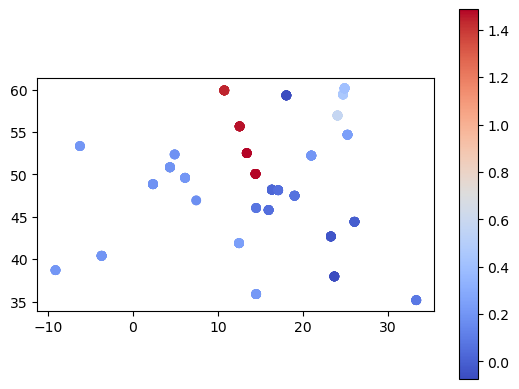

In [23]:
# Visualize results
gdf['GWR_intercept'] = results.params[:, 0]
gdf['GWR_slope'] = results.params[:, 1]

# Plot the map
gdf.plot(column='GWR_slope', cmap='coolwarm', legend=True)

In [24]:
# Load Europe shapefile from an online resource
world = gpd.read_file('world.gpkg')

In [25]:
#world.to_file('world.gpkg', driver='GPKG')
#world.to_file('world.shp', driver='ESRI Shapefile')
world.to_file('world.geojson', driver='GeoJSON')

In [26]:
print(isinstance(world.geometry, str))
print(isinstance(world.geometry, pd.Series))
print(isinstance(world.geometry, gpd.GeoSeries))
print(world.crs)

False
True
True
EPSG:4326


<Axes: >

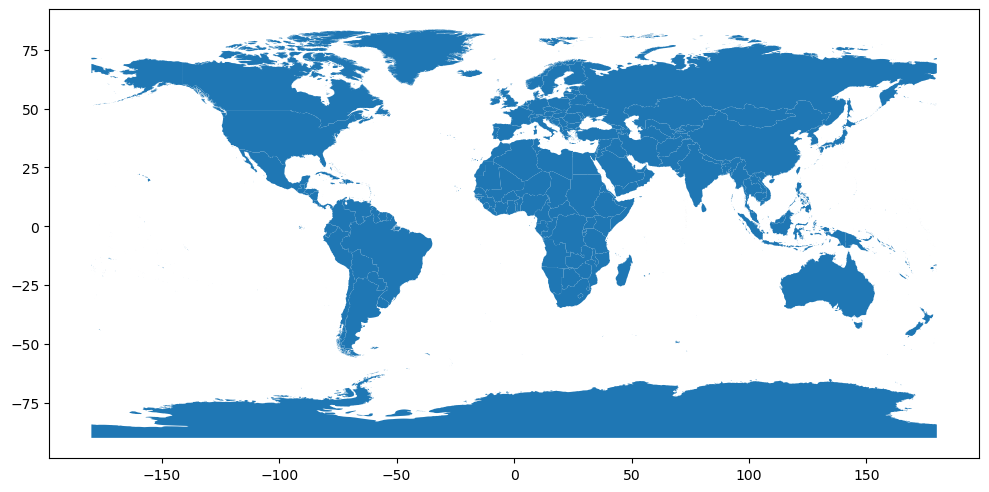

In [27]:
world2 = world.to_crs('epsg:4326')
world2.plot(figsize=(12,8))

In [28]:
# Filter Europe countries from the world shapefile
europe_countries = [
    'AUT', 'BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 
    'FRA', 'DEU', 'GRC', 'HUN', 'IRL', 'ITA', 'LVA', 'LTU', 'LUX', 
    'MLT', 'NLD', 'NOR', 'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP', 
    'SWE', 'CHE'
]
europe = world2[world2['ISO3'].isin(europe_countries)]

In [29]:
print(europe.columns)

Index(['FIPS', 'ISO2', 'ISO3', 'UN', 'NAME', 'AREA', 'POP2005', 'REGION',
       'SUBREGION', 'LON', 'LAT', 'geometry'],
      dtype='object')


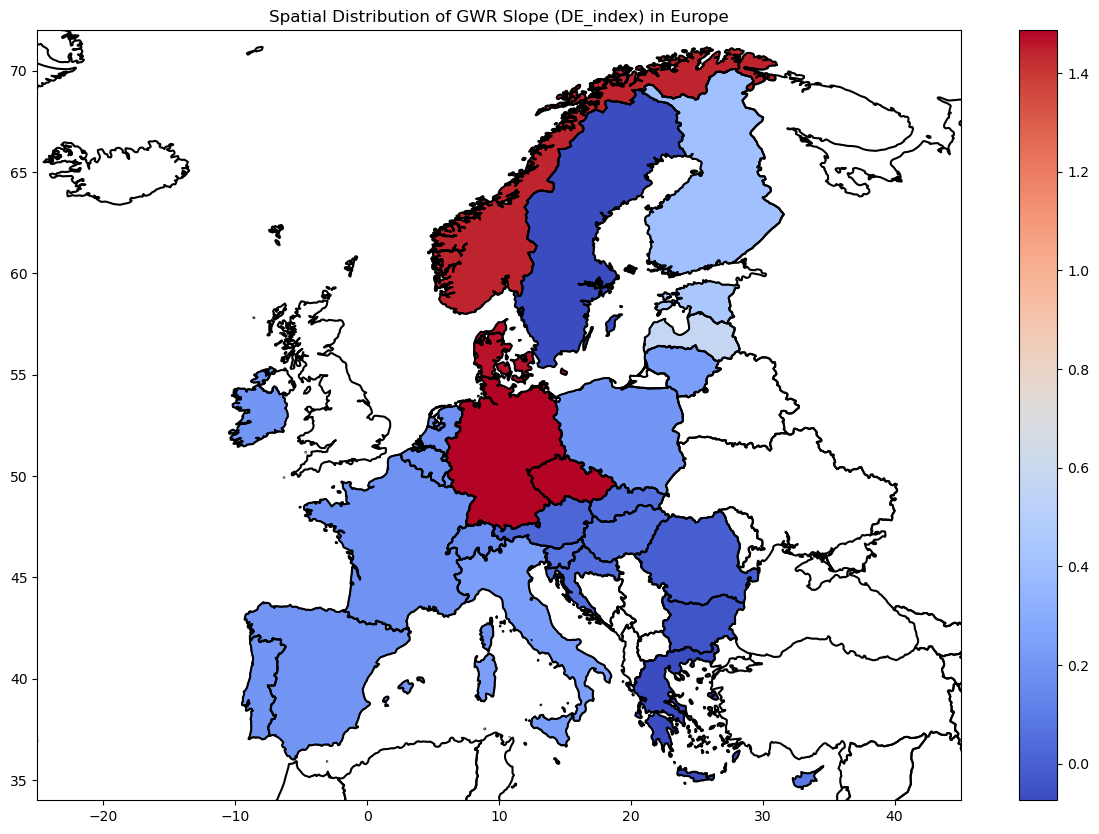

In [30]:
# Ensure the Europe shapefile has the correct CRS
europe.set_crs(epsg=4326, allow_override=True)

# Merge GWR results with Europe shapefile based on ISO3 codes
gdf = gdf.set_index('ISO3')
europe = europe.set_index('ISO3')

# Calculate the average slope for each country
average_slopes = gdf.groupby('ISO3')['GWR_slope'].mean()
europe['GWR_slope'] = average_slopes

# Plot the map for the slope values, focusing on Europe
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world2.boundary.plot(ax=ax, color='black')
europe.plot(column='GWR_slope', cmap='coolwarm', legend=True, ax=ax, edgecolor='black')
ax.set_title('Spatial Distribution of GWR Slope (DE_index) in Europe')

# Set the extent to focus on Europe
ax.set_xlim([-25, 45])
ax.set_ylim([34, 72])

plt.show()

In [50]:
import matplotlib.ticker as mticker

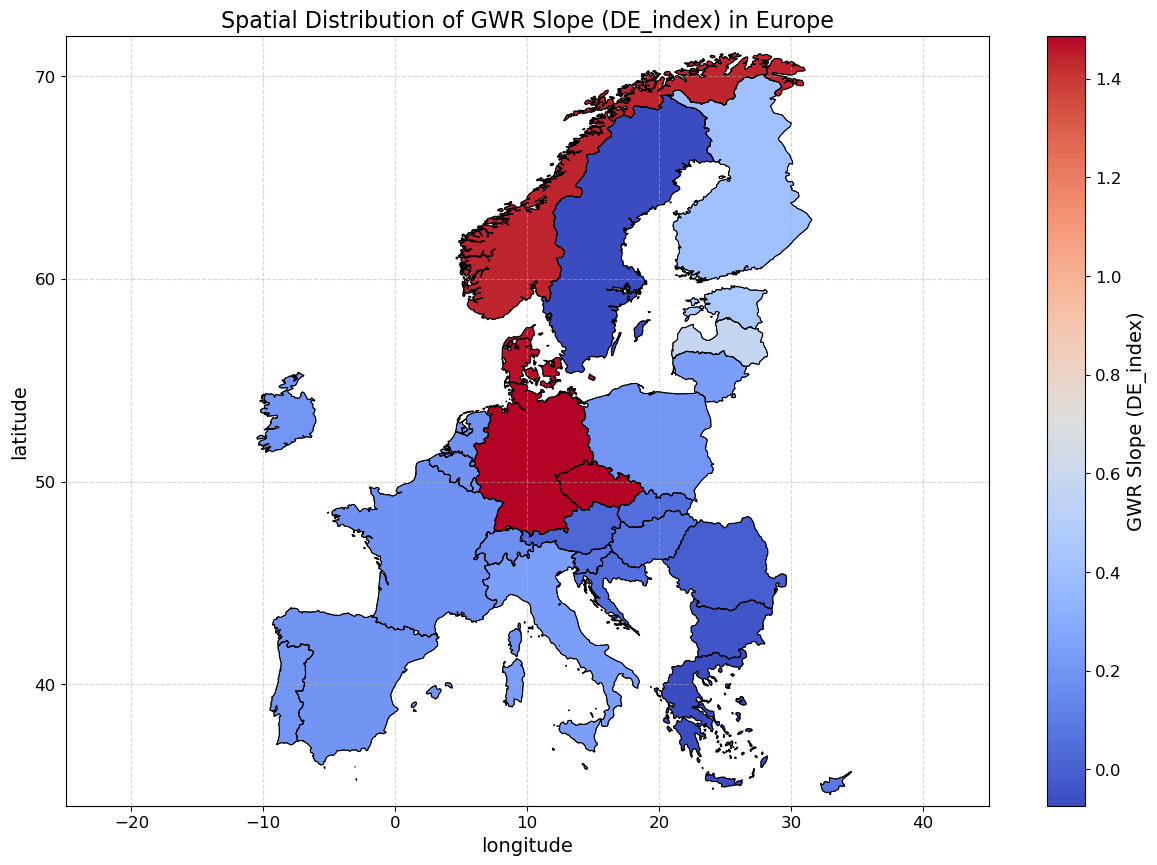

In [51]:
# Plot the map for the slope values, focusing on Europe
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Improve the colormap and plot appearance
europe.boundary.plot(ax=ax, color='black', linewidth=0.8)
europe.plot(column='GWR_slope', cmap='coolwarm', legend=True, ax=ax, edgecolor='black', linewidth=0.5)

# Add a more descriptive title
ax.set_title('Spatial Distribution of GWR Slope (DE_index) in Europe', fontsize=16)

# Set the extent to focus on Europe
ax.set_xlim([-25, 45])
ax.set_ylim([34, 72])

# Improve axis labels and ticks
ax.set_xlabel('longitude', fontsize=14)
ax.set_ylabel('latitude', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.xaxis.set_major_locator(mticker.MultipleLocator(10))
ax.yaxis.set_major_locator(mticker.MultipleLocator(10))

# Customize the legend
cbar = ax.get_figure().get_axes()[1]
cbar.tick_params(labelsize=12)
cbar.set_ylabel('GWR Slope (DE_index)', fontsize=14)

# Add a grid for better readability
ax.grid(True, linestyle='--', alpha=0.5)

plt.show()


In [31]:
print(gdf.columns)

Index(['country', 'year', 'broadband', 'telephone', 'cellular', 'internet',
       'credit', 'education', 'ict', 'tech', 'patent_residents',
       'patent_nonresidents', 'researchers', 'RD', 'gdppc', 'urban',
       'articles', 'business', 'fdi_outflow', 'fdi_inflow', 'gdp',
       'gdp_growth', 'latitude', 'longitude', 'patent', 'DE_index',
       'Innovation_index', 'geometry', 'GWR_intercept', 'GWR_slope'],
      dtype='object')


In [32]:
'''
# Ensure the Europe shapefile has the correct CRS (assuming it is also WGS84)
europe.set_crs(epsg=4326, inplace=True)
# Merge GWR results with Europe shapefile based on country names
gdf = gdf.set_index('ISO3').join(europe.set_index('ISO3'), rsuffix='_shape')
'''

"\n# Ensure the Europe shapefile has the correct CRS (assuming it is also WGS84)\neurope.set_crs(epsg=4326, inplace=True)\n# Merge GWR results with Europe shapefile based on country names\ngdf = gdf.set_index('ISO3').join(europe.set_index('ISO3'), rsuffix='_shape')\n"

In [33]:
'''
# 绘制斜率值的地图
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
europe.boundary.plot(ax=ax, color='black')
gdf.plot(column='GWR_slope', cmap='coolwarm', legend=True, ax=ax, edgecolor='black')
ax.set_title('Spatial Distribution of GWR Slope (DE_index) in Europe')
plt.show()
'''

"\n# 绘制斜率值的地图\nfig, ax = plt.subplots(1, 1, figsize=(15, 10))\neurope.boundary.plot(ax=ax, color='black')\ngdf.plot(column='GWR_slope', cmap='coolwarm', legend=True, ax=ax, edgecolor='black')\nax.set_title('Spatial Distribution of GWR Slope (DE_index) in Europe')\nplt.show()\n"

In [34]:
print(gdf.columns)
print(europe.columns)

Index(['country', 'year', 'broadband', 'telephone', 'cellular', 'internet',
       'credit', 'education', 'ict', 'tech', 'patent_residents',
       'patent_nonresidents', 'researchers', 'RD', 'gdppc', 'urban',
       'articles', 'business', 'fdi_outflow', 'fdi_inflow', 'gdp',
       'gdp_growth', 'latitude', 'longitude', 'patent', 'DE_index',
       'Innovation_index', 'geometry', 'GWR_intercept', 'GWR_slope'],
      dtype='object')
Index(['FIPS', 'ISO2', 'UN', 'NAME', 'AREA', 'POP2005', 'REGION', 'SUBREGION',
       'LON', 'LAT', 'geometry', 'GWR_slope'],
      dtype='object')


In [35]:
# 查看 world2 数据框的列名
print(world2.columns)

# 查看 world2 数据框的前几行
print(world2.head(20))



Index(['FIPS', 'ISO2', 'ISO3', 'UN', 'NAME', 'AREA', 'POP2005', 'REGION',
       'SUBREGION', 'LON', 'LAT', 'geometry'],
      dtype='object')
   FIPS ISO2 ISO3   UN                    NAME    AREA   POP2005  REGION  \
0    AC   AG  ATG   28     Antigua and Barbuda      44     83039      19   
1    AG   DZ  DZA   12                 Algeria  238174  32854159       2   
2    AJ   AZ  AZE   31              Azerbaijan    8260   8352021     142   
3    AL   AL  ALB    8                 Albania    2740   3153731     150   
4    AM   AM  ARM   51                 Armenia    2820   3017661     142   
5    AO   AO  AGO   24                  Angola  124670  16095214       2   
6    AQ   AS  ASM   16          American Samoa      20     64051       9   
7    AR   AR  ARG   32               Argentina  273669  38747148      19   
8    AS   AU  AUS   36               Australia  768230  20310208       9   
9    BA   BH  BHR   48                 Bahrain      71    724788     142   
10   BB   BB  BRB   5

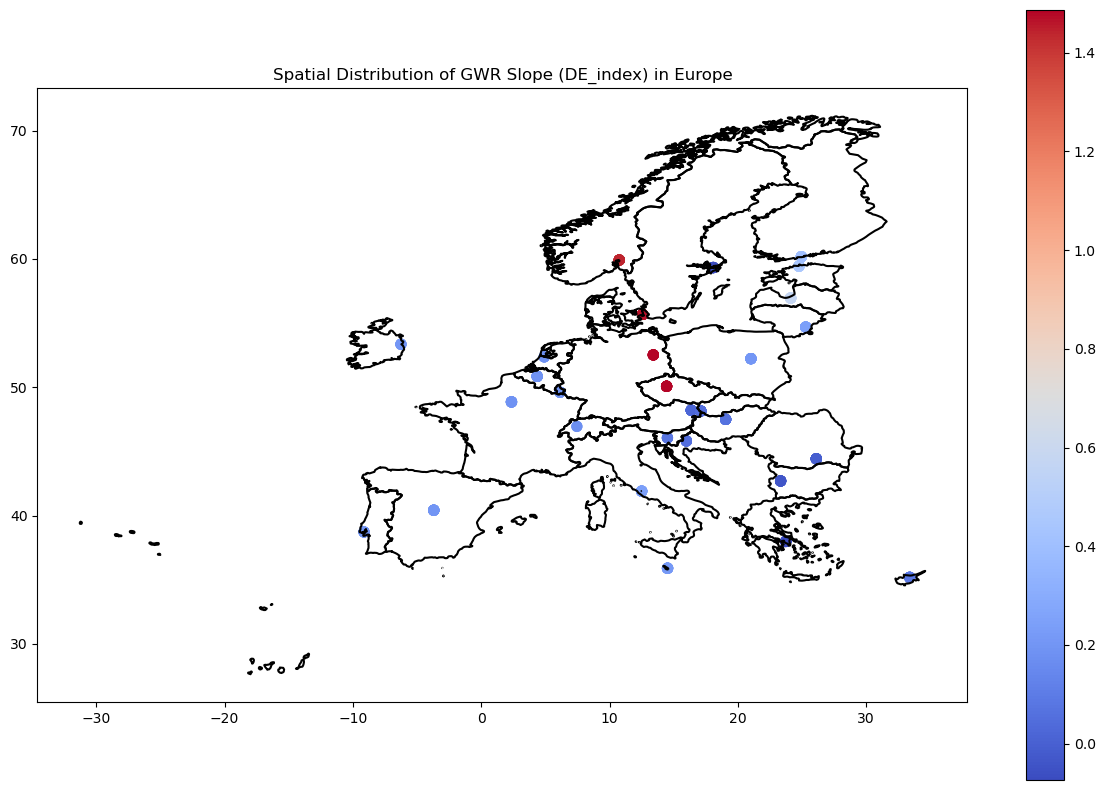

In [36]:
# Plot the map for the slope (relationship strength)
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
europe.boundary.plot(ax=ax, color='black')
gdf.plot(column='GWR_slope', cmap='coolwarm', legend=True, ax=ax, markersize=50)
ax.set_title('Spatial Distribution of GWR Slope (DE_index) in Europe')
plt.show()

# Spatial Autocorrelation

## Weight matrix

### 1.Geographical Distance Matrix

In [37]:
# Extract the country names and coordinates
countries = data['country']
coordinates = data[['latitude', 'longitude']].values

In [38]:
# Calculate the geographical distance matrix
num_countries = len(countries)
distances = np.zeros((num_countries, num_countries))

for i in range(num_countries):
    for j in range(num_countries):
        if i != j:
            distances[i, j] = geodesic(coordinates[i], coordinates[j]).kilometers
        else:
            distances[i, j] = 0  # Distance to itself is 0

In [39]:
# Add a small value to non-diagonal zero elements to avoid infinite weights
epsilon = 1e-5
distances[distances == 0] = epsilon

# Print the geographical distance matrix
print("Geographical Distance Matrix:")
print(distances)

Geographical Distance Matrix:
[[1.00000000e-05 1.00000000e-05 1.00000000e-05 ... 1.24256409e+03
  6.84852340e+02 6.84852340e+02]
 [1.00000000e-05 1.00000000e-05 1.00000000e-05 ... 1.24256409e+03
  6.84852340e+02 6.84852340e+02]
 [1.00000000e-05 1.00000000e-05 1.00000000e-05 ... 1.24256409e+03
  6.84852340e+02 6.84852340e+02]
 ...
 [1.24256409e+03 1.24256409e+03 1.24256409e+03 ... 1.00000000e-05
  1.54608161e+03 1.54608161e+03]
 [6.84852340e+02 6.84852340e+02 6.84852340e+02 ... 1.54608161e+03
  1.00000000e-05 1.00000000e-05]
 [6.84852340e+02 6.84852340e+02 6.84852340e+02 ... 1.54608161e+03
  1.00000000e-05 1.00000000e-05]]


In [40]:
# Construct the geographical distance weight matrix (inverse square of distances)
W1 = np.zeros_like(distances)
with np.errstate(divide='ignore', invalid='ignore'):
    W1 = 1 / distances
    W1[distances == 0] = 0  # Set diagonal to 0 to avoid division by zero


In [41]:
# Print the geographical distance weight matrix
print("Geographical Distance Weight Matrix:")
print(W1)

Geographical Distance Weight Matrix:
[[1.00000000e+05 1.00000000e+05 1.00000000e+05 ... 8.04787459e-04
  1.46016877e-03 1.46016877e-03]
 [1.00000000e+05 1.00000000e+05 1.00000000e+05 ... 8.04787459e-04
  1.46016877e-03 1.46016877e-03]
 [1.00000000e+05 1.00000000e+05 1.00000000e+05 ... 8.04787459e-04
  1.46016877e-03 1.46016877e-03]
 ...
 [8.04787459e-04 8.04787459e-04 8.04787459e-04 ... 1.00000000e+05
  6.46796386e-04 6.46796386e-04]
 [1.46016877e-03 1.46016877e-03 1.46016877e-03 ... 6.46796386e-04
  1.00000000e+05 1.00000000e+05]
 [1.46016877e-03 1.46016877e-03 1.46016877e-03 ... 6.46796386e-04
  1.00000000e+05 1.00000000e+05]]


In [42]:
# Save the weight matrix to a CSV file for later use
#np.savetxt('geographical_distance_weight_matrix.csv', W1, delimiter=',')

In [43]:
#distance_matrix.csv', distances, delimiter=',')

### 2.Economic Distance Matrix

In [44]:
# Extract the country names and GDP per capita
countries = data['country']
gdp_per_capita = data['gdppc'].values

# Calculate the economic distance matrix
num_countries = len(countries)
economic_distances = np.zeros((num_countries, num_countries))

for i in range(num_countries):
    for j in range(num_countries):
        if i != j:
            economic_distances[i, j] = abs(gdp_per_capita[i] - gdp_per_capita[j])
        else:
            economic_distances[i, j] = 0  # Distance to itself is 0

# Print the economic distance matrix
print("Economic Distance Matrix:")
print(economic_distances)

Economic Distance Matrix:
[[    0.        679.31683  1795.80806 ...  9297.481   39309.69429
  41151.25547]
 [  679.31683     0.       1116.49123 ...  8618.16417 38630.37746
  40471.93864]
 [ 1795.80806  1116.49123     0.      ...  7501.67294 37513.88623
  39355.44741]
 ...
 [ 9297.481    8618.16417  7501.67294 ...     0.      30012.21329
  31853.77447]
 [39309.69429 38630.37746 37513.88623 ... 30012.21329     0.
   1841.56118]
 [41151.25547 40471.93864 39355.44741 ... 31853.77447  1841.56118
      0.     ]]


In [45]:
# Construct the economic distance weight matrix (inverse of economic distances)
W2 = np.zeros_like(economic_distances)
with np.errstate(divide='ignore', invalid='ignore'):
    W2 = 1 / economic_distances
    W2[economic_distances == 0] = 0  # Set diagonal to 0 to avoid division by zero

# Print the economic distance weight matrix
print("Economic Distance Weight Matrix:")
print(W2)

Economic Distance Weight Matrix:
[[0.00000000e+00 1.47206716e-03 5.56852384e-04 ... 1.07556014e-04
  2.54390175e-05 2.43005952e-05]
 [1.47206716e-03 0.00000000e+00 8.95663103e-04 ... 1.16033993e-04
  2.58863637e-05 2.47084779e-05]
 [5.56852384e-04 8.95663103e-04 0.00000000e+00 ... 1.33303599e-04
  2.66567957e-05 2.54094431e-05]
 ...
 [1.07556014e-04 1.16033993e-04 1.33303599e-04 ... 0.00000000e+00
  3.33197685e-05 3.13934539e-05]
 [2.54390175e-05 2.58863637e-05 2.66567957e-05 ... 3.33197685e-05
  0.00000000e+00 5.43017528e-04]
 [2.43005952e-05 2.47084779e-05 2.54094431e-05 ... 3.13934539e-05
  5.43017528e-04 0.00000000e+00]]


### Economic-Geographical Matrix

In [46]:
W3 = W1 * W2

In [47]:
# Calculate Moran's I using the economic-geographical weight matrix
# Convert the economic-geographical weight matrix to a pysal weights object
w3 = full2W(W3)

moran = Moran(data['DE_index'], w3)

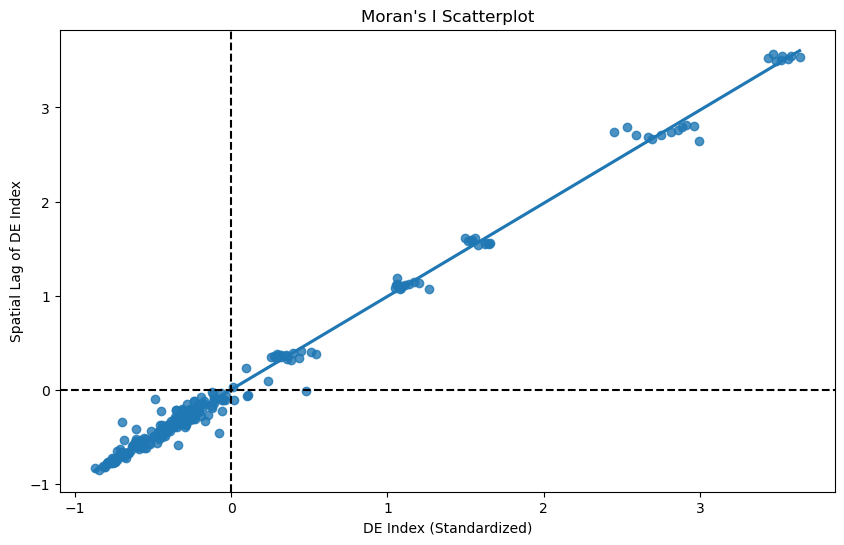

In [48]:
# Manually create the Moran scatter plot
z = (data['DE_index'] - data['DE_index'].mean()) / data['DE_index'].std()
wz = w3.sparse @ z

plt.figure(figsize=(10, 6))
sns.regplot(x=z, y=wz, ci=None)
plt.axhline(0, color='k', linestyle='--')
plt.axvline(0, color='k', linestyle='--')
plt.title("Moran's I Scatterplot")
plt.xlabel("DE Index (Standardized)")
plt.ylabel("Spatial Lag of DE Index")
plt.show()


# Innovation Efficiency

## Stochastic Frontier Analysis